<a href="https://colab.research.google.com/github/danchaud-vincent/tensorflow-deep-learning/blob/main/exercices-solutions/05_Transfer_Learning_in_TensorFlow_Part_2_Fine_tuning_Exercise_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 05 - Transfer Learning in TensorFlow Part 2: Fine-tuning Exercices


**Questions:**


1. Use feature-extraction to train a transfer learning model on 10% of the Food Vision data for 10 epochs using `tf.keras.applications.EfficientNetB0` as the base model. Use the `ModelCheckpoint` callback to save the weights to file.
2. Fine-tune the last 20 layers of the base model you trained in 2 for another 10 epochs. How did it go?
3. Fine-tune the last 30 layers of the base model you trained in 2 for another 10 epochs. How dit it go ?
4. Write a function to visualize an image from any dataset (train or test file) and any class (e.g. "steak", "pizza",... etc), visualize it and make a prediction on it using a trained model.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

## Download and Explore the data

### Download the data

In [2]:
# getting the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2022-11-06 15:07:22--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.18.128, 142.250.153.128, 142.250.145.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.18.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  40.6MB/s    in 4.6s    

2022-11-06 15:07:27 (35.0 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
# unzip the folder 
import zipfile

path_file = "10_food_classes_10_percent.zip"

with zipfile.ZipFile(path_file,"r")  as zip_ref:
  zip_ref.extractall()

### Explore the folder containing the data

In [4]:
# Walk through the folder containing the data
import os
data_dir = "10_food_classes_10_percent"

for dirpath, foldername, filename in os.walk(data_dir):
  print(f"There are {len(filename)} files in : {dirpath}")

There are 0 files in : 10_food_classes_10_percent
There are 0 files in : 10_food_classes_10_percent/train
There are 75 files in : 10_food_classes_10_percent/train/grilled_salmon
There are 75 files in : 10_food_classes_10_percent/train/fried_rice
There are 75 files in : 10_food_classes_10_percent/train/ramen
There are 75 files in : 10_food_classes_10_percent/train/hamburger
There are 75 files in : 10_food_classes_10_percent/train/sushi
There are 75 files in : 10_food_classes_10_percent/train/pizza
There are 75 files in : 10_food_classes_10_percent/train/ice_cream
There are 75 files in : 10_food_classes_10_percent/train/chicken_curry
There are 75 files in : 10_food_classes_10_percent/train/chicken_wings
There are 75 files in : 10_food_classes_10_percent/train/steak
There are 0 files in : 10_food_classes_10_percent/test
There are 250 files in : 10_food_classes_10_percent/test/grilled_salmon
There are 250 files in : 10_food_classes_10_percent/test/fried_rice
There are 250 files in : 10_foo

In [5]:
# get the class names 
import pathlib

train_dir = "10_food_classes_10_percent/train"
data_dir = pathlib.Path(train_dir)
class_names = sorted([item.name for item in data_dir.glob("*")])

class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

### Visualize the data

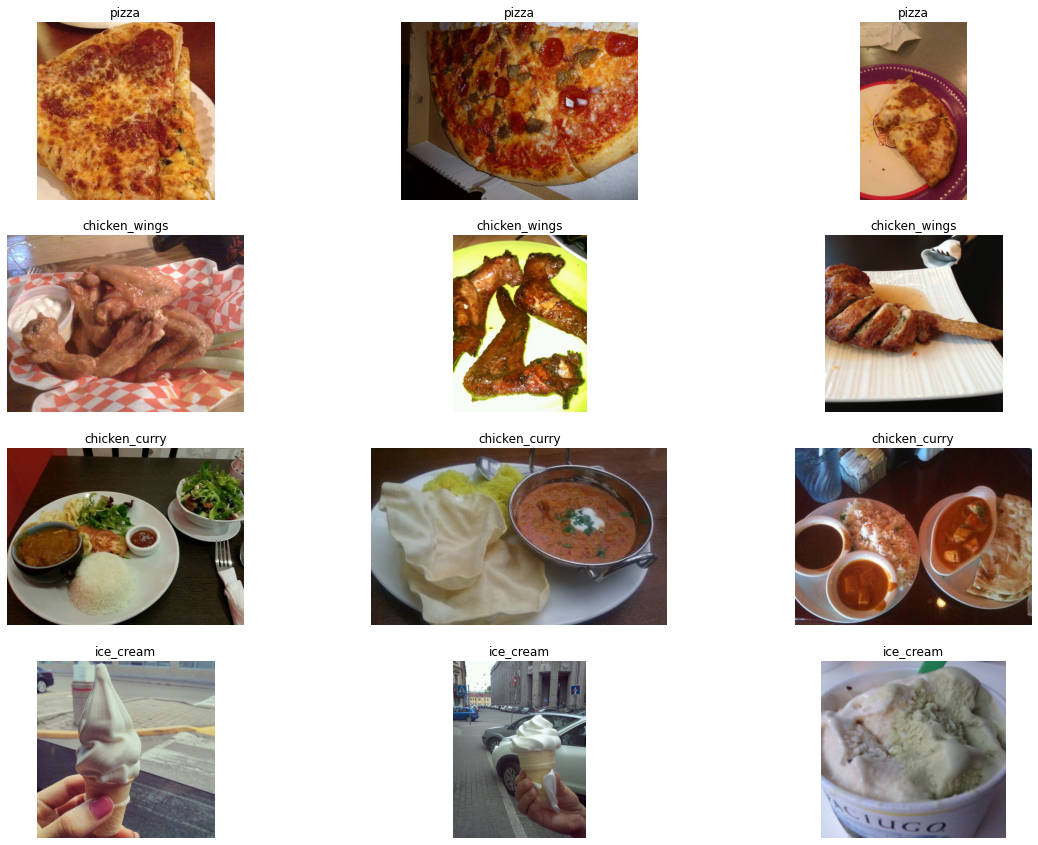

In [6]:
# get random images and visualize it
import random
import matplotlib.image as mpimg

# set number of classes and images to visualiz
nb_image_per_class = 3
nb_classes = 4

# set the train directory
train_dir = "10_food_classes_10_percent/train" 

# get random classes from the list of classes
random_classes = random.sample(class_names, nb_classes)

# create a figure
plt.figure(figsize=(20,15))
index = 1

for i, item_class in enumerate(random_classes):

  # set the class directory
  class_dir = train_dir + "/" + item_class

  # list of the images in the class directory
  list_images = os.listdir(class_dir)

  # get random images
  random_images = random.sample(list_images,nb_image_per_class)

  for j, image_item in enumerate(random_images):

    # set the image directory
    image_dir = class_dir + "/" + image_item

    # read the image
    img = mpimg.imread(image_dir)

    # visualize the image
    plt.subplot(nb_classes,nb_image_per_class, index)
    plt.imshow(img)
    plt.axis("off")
    plt.title(item_class)

    index += 1

In [7]:
# visualize the array of an image
class_name = "hamburger"
list_images = os.listdir(f"{train_dir}/{class_name}")
random_image = random.sample(list_images, 1)[0]

img = mpimg.imread(f"{train_dir}/{class_name}/{random_image}")

print(f"Shape of the img: {img.shape}")
print(f"Max value in the array: {img.max()}")
print(f"Min value in the array:{img.min()}")
print(img)

Shape of the img: (512, 512, 3)
Max value in the array: 255
Min value in the array:0
[[[138  58  31]
  [139  58  31]
  [141  60  31]
  ...
  [115  53  38]
  [118  55  40]
  [121  58  43]]

 [[139  58  31]
  [138  57  30]
  [139  58  29]
  ...
  [117  55  40]
  [118  56  41]
  [120  57  42]]

 [[142  61  34]
  [140  59  30]
  [140  59  30]
  ...
  [119  57  42]
  [119  57  42]
  [119  56  41]]

 ...

 [[140 164  90]
  [139 163  89]
  [134 160  86]
  ...
  [167 219 147]
  [178 230 156]
  [186 238 163]]

 [[137 161  87]
  [132 156  82]
  [133 159  85]
  ...
  [166 220 145]
  [174 231 154]
  [181 238 159]]

 [[129 152  80]
  [141 165  91]
  [146 172  98]
  ...
  [161 217 142]
  [169 226 147]
  [175 232 151]]]


## Build a transfer learning model using the Keras Functional API

### Preprocess the data

In [8]:
# set the train and test dir
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [9]:
# Create data inputs
IMG_SIZE = (224,224)
BATCH_SIZE = 32

print("--- train dataset ---")
train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                 image_size=IMG_SIZE,
                                                                 label_mode="categorical",
                                                                 batch_size=BATCH_SIZE)

print("--- test dataset ---")
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical",
                                                                batch_size=BATCH_SIZE)

--- train dataset ---
Found 750 files belonging to 10 classes.
--- test dataset ---
Found 2500 files belonging to 10 classes.


In [10]:
# Check the train_data datatype
train_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [11]:
# class names of the train_data
train_data.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [12]:
# See an example of a batch of data
train_data.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [13]:
for images,labels in train_data.take(1):
  print(images)
  print(labels)

tf.Tensor(
[[[[2.51581631e+01 1.41581631e+01 1.01581631e+01]
   [2.82602043e+01 1.72602043e+01 1.52602043e+01]
   [2.97857132e+01 1.57857141e+01 1.47857141e+01]
   ...
   [3.26223717e+01 2.65458488e+01 3.07754173e+01]
   [2.90203991e+01 2.00203991e+01 2.16836548e+01]
   [3.04183178e+01 2.24183178e+01 2.04183178e+01]]

  [[3.19030628e+01 1.79030609e+01 1.49030619e+01]
   [2.80000000e+01 1.40000000e+01 1.10000000e+01]
   [3.07704067e+01 1.67704067e+01 1.57704077e+01]
   ...
   [1.19178070e+02 1.15106644e+02 1.16320930e+02]
   [6.52752991e+01 5.92752953e+01 5.92752953e+01]
   [3.42291985e+01 2.92291985e+01 2.62291985e+01]]

  [[3.31326561e+01 1.89183674e+01 1.59183674e+01]
   [2.96989803e+01 1.54846935e+01 1.24846935e+01]
   [3.12142868e+01 1.66632652e+01 1.41683674e+01]
   ...
   [2.23821198e+02 2.20969116e+02 2.19157898e+02]
   [1.88035477e+02 1.84678329e+02 1.83035477e+02]
   [1.36667511e+02 1.33310364e+02 1.30096069e+02]]

  ...

  [[1.28622589e+01 1.08622589e+01 1.34337311e+01]
   [1

### Build a Tensorboard callback and a ModelCheckpoint callback

In [14]:
# Tensorboard callback
import datetime

def create_tensorboard_callback(dirname, experiment_name):
  """
  Create a tensorboard callback

  Arguments:
  - dirname (str): target directory to stores TensorBoard log files
  - experiment_name (str): name of the experiment directory

  Returns:
  - tensorboar_callback
  """
  # get the time
  time_now = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")

  # path of the directory to save the log files
  log_dir = f"{dirname}/{experiment_name}/{time_now}"

  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

  return tensorboard_callback

In [15]:
# Create a ModelCheckpoint

# checkpoint path
checkpoint_path = "model_checkpoints/checkpoint.ckpt"

# Create a ModelCheckpoint to save best weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=True,
                                                         monitor='val_accuracy',
                                                         verbose=1)

### Build a model using Functional API and EfficientNetb0

In [16]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model

In [17]:
# Build feature extraction transfer learning model with the Functional API
IMG_SHAPE = (224,224,3)

# set the base model (EfficientNetB0), include_top=False for feature extraction
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# set the inputs
inputs = tf.keras.Input(shape=IMG_SHAPE, name="input_layer")

# create the model
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling2D_layer")(x)
outputs = layers.Dense(len(train_data.class_names), activation="softmax", name="output_layer")(x)
model = Model(inputs, outputs)

16705208/16705208 [==============================] - 1s 0us/step


In [18]:
# summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2D_la  (None, 1280)             0         
 yer (GlobalAveragePooling2D                                     
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [19]:
# Compile the model
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [20]:
len(train_data)

24

In [21]:
# fit the model
initial_epochs = 5

history_model_1 = model.fit(train_data,
                            epochs=initial_epochs,
                            steps_per_epoch=len(train_data),
                            validation_data=test_data,
                            validation_steps=int(0.25*len(test_data)),
                            callbacks=[create_tensorboard_callback(dirname="transfer_learning_tensorboard", experiment_name="feature_extraction_EfficentNetB0"),
                                       checkpoint_callback])

Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.8486 - accuracy: 0.4467
Epoch 1: val_accuracy improved from -inf to 0.72862, saving model to model_checkpoints/checkpoint.ckpt
24/24 [==============================] - 95s 4s/step - loss: 1.8486 - accuracy: 0.4467 - val_loss: 1.3038 - val_accuracy: 0.7286
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.0567 - accuracy: 0.7760
Epoch 2: val_accuracy improved from 0.72862 to 0.81908, saving model to model_checkpoints/checkpoint.ckpt
24/24 [==============================] - 87s 4s/step - loss: 1.0567 - accuracy: 0.7760 - val_loss: 0.8781 - val_accuracy: 0.8191
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.7527 - accuracy: 0.8333
Epoch 3: val_accuracy improved from 0.81908 to 0.85691, saving model to model_checkpoints/checkpoint.ckpt
24/24 [==============================] - 88s 4s/step - loss: 0.7527 - accuracy: 0.8333 - val_loss: 0.6712 - val_accuracy: 0.8569
Epoch 4/5
24/24 [==

In [22]:
# evaluate the model on all of the test data
model.evaluate(test_data)

79/79 [==============================] - 162s 2s/step - loss: 0.5551 - accuracy: 0.8684


[0.5551495552062988, 0.868399977684021]

In [32]:
# visualize the result
def plot_history_result(history):
  """
  Plot the accuracy and loss results of a trained model

  Arguments:
  - history: history of a trained model
  """
  # create dataframe
  df_history = pd.DataFrame(history)

  # loss
  train_loss = df_history["loss"]
  val_loss = df_history["val_loss"]

  # accuracy
  train_accuracy = df_history["accuracy"]
  val_accuracy = df_history["val_accuracy"]

  # figure
  fig, ax = plt.subplots(1,2,figsize=(18,7))

  ax[0].plot(train_loss,  label="train loss")
  ax[0].plot(val_loss, label="validation loss")
  ax[0].legend()
  ax[0].set_title("Loss")

  ax[1].plot(train_accuracy,  label="train accuracy")
  ax[1].plot(val_accuracy, label="validation accuracy")
  ax[1].legend()
  ax[1].set_title("Accuracy")
  plt.show()

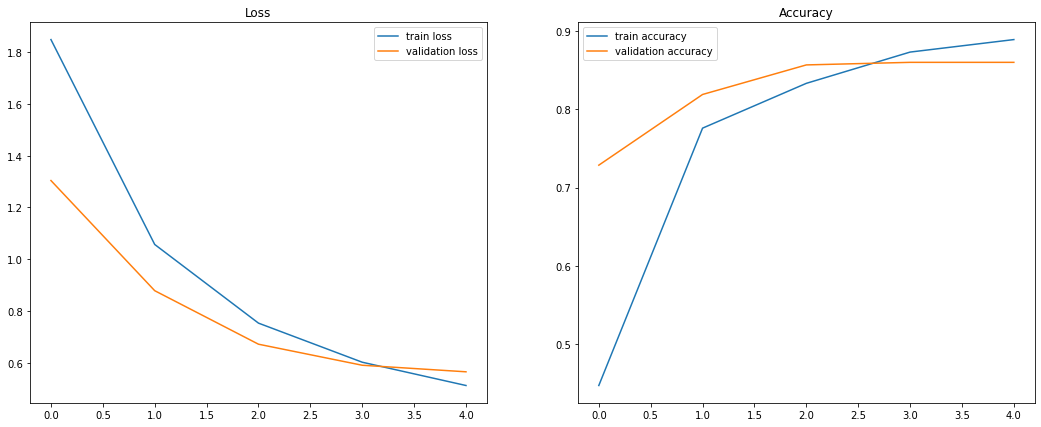

In [34]:
plot_history_result(history_model_1.history)

### Fine-tune our model on the 20 last layers

In [37]:
# Check the layers of our model
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
efficientnetb0 False
global_average_pooling2D_layer True
output_layer True


In [43]:
# Check the layers of the EfficientNetB0 model
for layer in model.layers[1].layers:
  print(layer.name, layer.trainable)

input_1 False
rescaling False
normalization False
tf.math.truediv False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_dwconv False
block2b_bn False
block2b_activation False
block2b_se_squeeze False
block2b_se_reshape False
block2b_se_reduce False
block2b_se_expand False
block2b_se_excite False
block2b_

In [52]:
# Fine-tune our model on the 20 last layers
base_model.trainable = True

for layer in base_model.layers[:-20]:
  layer.trainable = False

In [54]:
# Check the layers in our base model
for layer in model.layers[1].layers:
  print(layer.name, layer.trainable)

input_1 False
rescaling False
normalization False
tf.math.truediv False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_dwconv False
block2b_bn False
block2b_activation False
block2b_se_squeeze False
block2b_se_reshape False
block2b_se_reduce False
block2b_se_expand False
block2b_se_excite False
block2b_

In [55]:
# Recompile the model because we make a change
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

In [62]:
initial_epochs

5

In [63]:
# Fine tune for 10 more epochs
fine_tune_epochs = initial_epochs + 10

history_model_fineTune_1 = model.fit(train_data,
                                     epochs=fine_tune_epochs,
                                     steps_per_epoch=len(train_data),
                                     validation_data=test_data,
                                     validation_steps=int(0.25*len(test_data)),
                                     initial_epoch=history_model_1.epoch[-1],
                                     callbacks=[create_tensorboard_callback(dirname="transfer_learning_tensorboard", experiment_name="fine_tune_EfficientNetB0")])

Epoch 5/15
24/24 [==============================] - 148s 6s/step - loss: 0.4011 - accuracy: 0.8920 - val_loss: 0.3868 - val_accuracy: 0.8832
Epoch 6/15
24/24 [==============================] - 138s 6s/step - loss: 0.2417 - accuracy: 0.9453 - val_loss: 0.3765 - val_accuracy: 0.8766
Epoch 7/15
24/24 [==============================] - 137s 6s/step - loss: 0.1584 - accuracy: 0.9667 - val_loss: 0.3463 - val_accuracy: 0.8882
Epoch 8/15
24/24 [==============================] - 138s 6s/step - loss: 0.1067 - accuracy: 0.9800 - val_loss: 0.3413 - val_accuracy: 0.8898
Epoch 9/15
24/24 [==============================] - 97s 4s/step - loss: 0.0682 - accuracy: 0.9933 - val_loss: 0.4106 - val_accuracy: 0.8766
Epoch 10/15
24/24 [==============================] - 97s 4s/step - loss: 0.0447 - accuracy: 0.9987 - val_loss: 0.4266 - val_accuracy: 0.8701
Epoch 11/15
24/24 [==============================] - 137s 6s/step - loss: 0.0293 - accuracy: 0.9987 - val_loss: 0.3232 - val_accuracy: 0.8914
Epoch 12/15
2

In [64]:
# evaluate on the all test_data
model.evaluate(test_data)

79/79 [==============================] - 169s 2s/step - loss: 0.4237 - accuracy: 0.8764


[0.4237156808376312, 0.8763999938964844]

In [103]:
len(history_model_fineTune_1.epoch)

11

In [126]:
# Visualize the results of the fine tuning
def plot_histories_results(old_history, new_history):
  """
  Plot the results of a model before fine-tuning and after fine-tuning

  Arguments:
  - old_history: history of the trained model before fine-tuning
  - new_history: history of the trained model after fine-tuning
  """
  # old_history epoch
  old_history_epochs = len(old_history.epoch)
  
  # new history epochs
  new_history_epochs = len(new_history.epoch)

  # create dataframes
  df_old_history = pd.DataFrame(old_history.history, index=range(old_history_epochs))
  df_new_history = pd.DataFrame(new_history.history, index=range(old_history_epochs,new_history_epochs+old_history_epochs))
  df = pd.concat([df_old_history,df_new_history], axis=0)

  # figures
  fig, ax = plt.subplots(1,2, figsize=(18,7))
  df[["loss","val_loss"]].plot(ax=ax[0], title="Loss")
  df[["accuracy","val_accuracy"]].plot(ax=ax[1], title="Accuracy")

  ax[0].axvline(old_history_epochs, color="g", linestyle = "--")
  ax[1].axvline(old_history_epochs, color="g", linestyle = "--")
  plt.show()

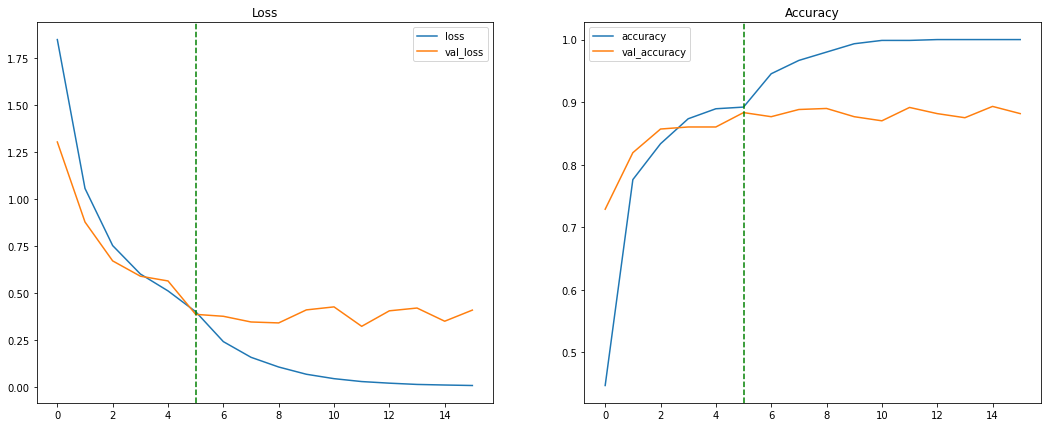

In [127]:
plot_histories_results(history_model_1, history_model_fineTune_1)

### Fine-tune our model on the 30 layers 

In [130]:
# load our saved model
model.load_weights(checkpoint_path)

In [131]:
# Checking the model layers
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
efficientnetb0 True
global_average_pooling2D_layer True
output_layer True


In [135]:
# Fine tune the model (unfreeze the last 30 layers of the EfficientNetB0 base_model)
base_model.trainable = True

for layer in base_model.layers[:-30]:
  layer.trainable = False

In [136]:
# Check the layers 
for num, layer in enumerate(base_model.layers):
  print(num, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 tf.math.truediv False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [137]:
# Recompile the model
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

In [138]:
# fit the model
fine_tune_epochs = initial_epochs + 10

history_finetune_model_2 = model.fit(train_data,
                                     epochs=fine_tune_epochs,
                                     steps_per_epoch=len(train_data),
                                     validation_data=test_data,
                                     validation_steps=int(0.25*len(test_data)),
                                     initial_epoch=history_model_1.epoch[-1],
                                     callbacks=[create_tensorboard_callback(dirname="transfer_learning_tensorboard",experiment_name="fine_tune_30_EfficientNetB0")])

Epoch 5/15
24/24 [==============================] - 151s 6s/step - loss: 0.4532 - accuracy: 0.8680 - val_loss: 0.4654 - val_accuracy: 0.8454
Epoch 6/15
24/24 [==============================] - 141s 6s/step - loss: 0.2735 - accuracy: 0.9253 - val_loss: 0.3695 - val_accuracy: 0.8799
Epoch 7/15
24/24 [==============================] - 99s 4s/step - loss: 0.1749 - accuracy: 0.9600 - val_loss: 0.3842 - val_accuracy: 0.8750
Epoch 8/15
24/24 [==============================] - 100s 4s/step - loss: 0.1051 - accuracy: 0.9760 - val_loss: 0.3829 - val_accuracy: 0.8799
Epoch 9/15
24/24 [==============================] - 141s 6s/step - loss: 0.0713 - accuracy: 0.9867 - val_loss: 0.3723 - val_accuracy: 0.8684
Epoch 10/15
24/24 [==============================] - 100s 4s/step - loss: 0.0412 - accuracy: 0.9973 - val_loss: 0.4091 - val_accuracy: 0.8734
Epoch 11/15
24/24 [==============================] - 139s 6s/step - loss: 0.0237 - accuracy: 1.0000 - val_loss: 0.3750 - val_accuracy: 0.8799
Epoch 12/15


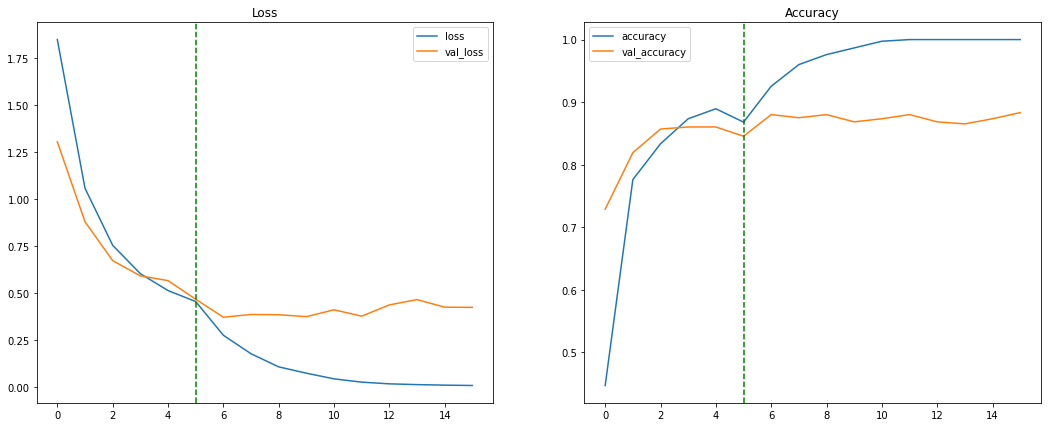

In [139]:
plot_histories_results(history_model_1, history_finetune_model_2)

## Visualize any dataset predictions

In [4]:
# take the first batch
image_batch , label_batch = train_data.as_numpy_iterator().next()

# make predictions on the images in the first batch
probs_batch = [model.predict(tf.expand_dims(img,axis=0)) for img in image_batch]
preds_batch = [class_names[np.argmax(prob)] for prob in probs_batch]


NameError: ignored